In [2]:
import sys
sys.path.append('../')

import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import radon, iradon
from pytranskit.optrans.continuous.radoncdt import RadonCDT
from pytranskit.optrans.utils import signal_to_pdf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.ndimage import filters
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


In [3]:
np.random.seed(123)
# Initialize RadonCDT object
radoncdt = RadonCDT()

# Generate 3 classes of k-modal two-dimensional Gaussians
N = 100  # Number of datapoints per class
sigma = 3  # Standard deviation of each Gaussian
# Initialize
I = np.zeros((3, N, 128, 128))
template = np.ones((128, 128))
K, L = radoncdt.forward(template, I[0, 0, :, :]+1e-8).shape
Ihat = np.zeros((3, N, K, L))
Ihat = np.random.randn(3, N, K, L)
# Generate dataset
for c in range(3):
  for i in range(N):
    for _ in range(c + 1):
      x, y = np.random.uniform(30, 98, (2,)).astype('int')
      I[c, i, x, y] = 1
    I[c, i, :, :] = I[c, i, :, :] / I[c, i, :, :].sum()
    I[c, i, :, :] = filters.gaussian_filter(I[c, i, :, :], sigma=sigma)
    Ihat[c, i, :, :] = radoncdt.forward(template, I[c, i, :, :])

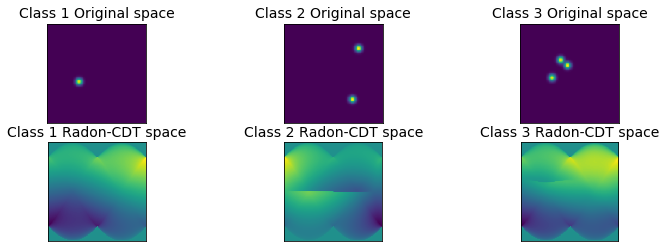

In [4]:

fig, ax = plt.subplots(2, 3, figsize=(12, 4))
title = ['Class 1', 'Class 2', 'Class 3']
for c in range(3):
  ind = np.random.randint(low=0, high=N)
  ax[0, c].imshow(I[c, ind, :, :])
  ax[0, c].set_xticks([])
  ax[0, c].set_yticks([])
  ax[0, c].set_title(title[c] + ' Original space', fontsize=14)
  ax[1, c].imshow(Ihat[c, ind, :, :])
  ax[1, c].set_xticks([])
  ax[1, c].set_yticks([])
  ax[1, c].set_title(title[c] + ' Radon-CDT space', fontsize=14)
plt.show()

/home/xy4cm/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/xy4cm/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/xy4cm/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


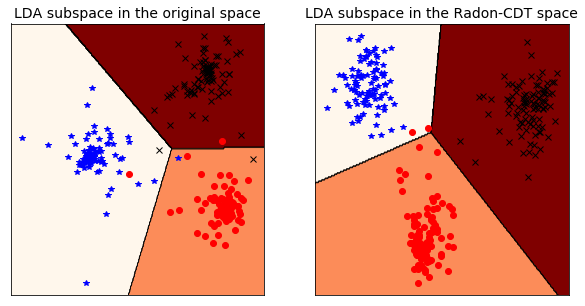

In [5]:
X=np.reshape(I,(3*N,128*128))
Xhat=np.reshape(Ihat,(3*N,K*L))
label=np.concatenate([np.ones(N), np.ones(N)+1, np.ones(N)+2])
lda=LDA(solver='svd', n_components=2)
n=N
# Apply LDA  in Signal Space
Xlda=lda.fit_transform(X,label)
svm=LinearSVC()
svm.fit(Xlda,label)
# Apply LDA in transform space 
Xhatlda=lda.fit_transform(Xhat,label)
svmhat=LinearSVC()
svmhat.fit(Xhatlda,label)
# Show classification boundaries in both Spaces
svmClassifier=[svm,svmhat]
Xdata=[Xlda,Xhatlda]
title=['LDA subspace in the original space','LDA subspace in the Radon-CDT space']
fig,ax=plt.subplots(1,2,figsize=(10,5))
for i in range(2):
    ax[i].plot(Xdata[i][:n,0],Xdata[i][:n,1],'b*')
    ax[i].plot(Xdata[i][n:2*n,0],Xdata[i][n:2*n,1],'ro')
    ax[i].plot(Xdata[i][2*n:,0],Xdata[i][2*n:,1],'kx')

    x_min, x_max = ax[i].get_xlim()
    y_min, y_max = ax[i].get_ylim()
    nx, ny = 400, 200
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = svmClassifier[i].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:].reshape(xx.shape)

    ax[i].pcolormesh(xx, yy, Z,cmap='OrRd')
    ax[i].contour(xx, yy, Z, linewidths=.5, colors='k')
    ax[i].set_title(title[i],fontsize=14)
    ax[i].set_xticks([])
    ax[i].set_yticks([])